In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import itertools
import logging
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as utils
import math
import time
import tqdm

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

import torch.nn as nn
import torch.nn.init as init

from flows import RealNVP, Planar, MAF
from models import NormalizingFlowModel

## Load and process the data

In [1]:
mode = 'ROC'

In [3]:
f_rnd = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5")

In [4]:
columns = f_rnd.columns

In [5]:
columns[[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]

Index(['Mj1', 'j1 tau21', 'j1 tau32', 'j1 tau43', 'j1 sqrt(tau^2_1)/tau^1_1',
       'j1 n_trk', 'j1 M_trim', 'j1 M_prun', 'j1 M_mmdt', 'j1 M_sdb1',
       'j1 M_sdb2', 'j1 M_sdm1', 'Mj2', 'j2 tau21', 'j2 tau32', 'j2 tau43',
       'j2 sqrt(tau^2_1)/tau^1_1', 'j2 n_trk', 'j2 M_trim', 'j2 M_prun',
       'j2 M_mmdt', 'j2 M_sdb1', 'j2 M_sdb2', 'j2 M_sdm1'],
      dtype='object')

In [49]:
columns[18]

'j1 M_sdm1'

In [50]:
f_rnd.head()

,Mjj,j1 pT,j2 pT,Mj1,j1 tau21,j1 tau32,j1 tau43,j1 tau54,j1 tau65,j1 tau76,...,j2 tau87,j2 sqrt(tau^2_1)/tau^1_1,j2 n_trk,j2 M_trim,j2 M_prun,j2 M_mmdt,j2 M_sdb1,j2 M_sdb2,j2 M_sdm1,isSignal
0,2577.571899,1285.895950,1282.286017,98.677270,0.528903,0.788281,0.904471,0.881570,0.911651,0.869766,...,0.865858,1.895988,128.0,42.162664,18.466533,18.466533,31.845136,42.162664,0.000000,0.0
1,3807.507389,1334.493332,1306.137883,584.595432,0.345626,0.463461,0.865982,0.892948,0.843223,0.939763,...,0.934968,1.377217,348.0,395.226881,393.309512,405.034096,405.034096,405.034096,405.034096,0.0
2,1710.965414,1072.462085,678.557182,159.597526,0.677692,0.690707,0.695322,0.823351,0.861655,0.909383,...,0.902637,1.887494,236.0,54.235070,41.967840,41.352112,51.721630,70.442364,-0.000003,0.0
3,2603.379037,1284.020224,1217.031950,515.237299,0.091038,0.784454,0.860716,0.887306,0.885916,0.950761,...,0.924068,1.997360,352.0,81.842001,60.307703,60.307703,72.423677,84.480859,0.000003,0.0
4,3294.162200,1205.343324,1087.658980,142.420213,0.507714,0.522686,0.904070,0.908468,0.918753,0.928911,...,0.906367,1.113248,204.0,103.456059,99.817788,103.456059,103.456059,103.456059,0.000008,1.0


In [51]:
if mode == 'ROC':
    dt = f_rnd.values
else:
    dt_PureBkg = dt_PureBkg = f_PureBkg.values

In [52]:
idx = dt[:,-1]
bkg_idx = np.where(idx==0)[0]
signal_idx = np.where(idx==1)[0]

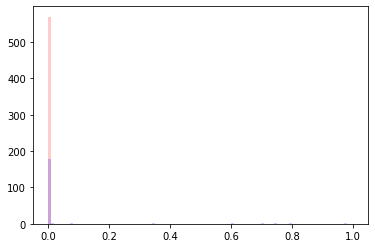

In [53]:
bins = np.linspace(0,1,101)
plt.hist(dt[signal_idx,33],bins,weights = np.ones(len(signal_idx))*(len(bkg_idx)/len(signal_idx)),alpha=0.2,color='r');
plt.hist(dt[bkg_idx,33],bins,alpha=0.2,color='b');

In [54]:
correct = (dt[:,3]>0) &(dt[:,19]>0)

In [55]:
dt = dt[correct]

In [56]:
dt.shape

(1099885, 36)

In [14]:
idx = dt[:,-1]
bkg_idx = np.where(idx==0)[0]
signal_idx = np.where((idx==1) & (dt[:,3]>300)) [0]

In [15]:
signal_idx.shape

(77119,)

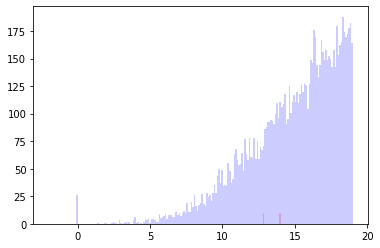

In [16]:
bins = np.linspace(-2,19,200)
plt.hist(dt[signal_idx,17],bins,weights = np.ones(len(signal_idx))*10,alpha=0.2,color='r');
plt.hist(dt[bkg_idx,17],bins,alpha=0.2,color='b');

In [17]:
correct = (dt[:,3]>200) &(dt[:,19]>20) & (dt[:, 4] > 0)& (dt[:, 5] > 0)& (dt[:, 6] > 0)& (dt[:, 7] > 0)& (dt[:, 8] > 0) & (dt[:, 20] > 0)& (dt[:, 21] > 0)& (dt[:, 22] > 0)& (dt[:, 23] > 0)& (dt[:, 24] > 0) & (dt[:, 25] > 0)& (dt[:, 26] > 0)


In [18]:
dt = dt[correct]

In [19]:
dt.shape

(534018, 36)

In [27]:
idx = dt[:,-1]
bkg_idx = np.where(idx==0)[0]
signal_idx = np.where(idx==1)[0]

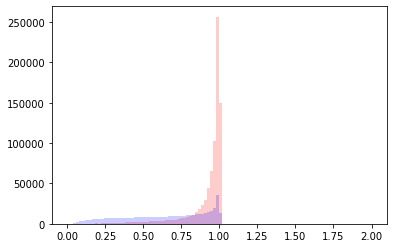

In [50]:
bins = np.linspace(0,2,101)
plt.hist(dt[signal_idx,32],bins,weights = np.ones(len(signal_idx))*10,alpha=0.2,color='r');
plt.hist(dt[bkg_idx,32],bins,alpha=0.2,color='b');

In [14]:
#for i in [4,5,6,7,8,9,10, 20, 21, 22, 23, 24, 25,26]:
    #X[:,i] = (X[:,i]-np.mean(X[:,i]))/np.std(X[:,i])
    #dt[:,i] = ((dt[:,i]-np.min(dt[:,i]))/(np.max(dt[:,i])-np.min(dt[:,i])))

In [50]:
for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]
    
for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])

In [17]:
#for i in [11,27,12,28,3,19]:
#    dt[:,i] = (dt[:,i]-np.min(dt[:,i]))/(np.max(dt[:,i])-np.min(dt[:,i]))

In [15]:
#X = np.concatenate((dt[:,3:18], dt[:,19:34]), axis=1)

In [16]:
#X = dt[:,3:34]

In [95]:
#CWoLa Variables
X = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]

In [96]:
X.shape

(1099885, 24)

In [111]:
bkg_mean = []
bkg_std = []

In [112]:
for i in range(24):
    bkg_mean.append(np.mean(X[:,i]))
    bkg_std.append(np.std(X[:,i]))
    X[:,i] = (X[:,i]-np.mean(X[:,i]))/np.std(X[:,i])

In [113]:
columns[13]

'j1 M_trim'

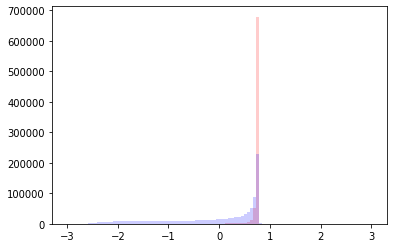

In [121]:
bins = np.linspace(-3,3,101)
plt.hist(X[signal_idx,9],bins,weights = np.ones(len(X[signal_idx,15]))*10,alpha=0.2,color='r');
plt.hist(X[bkg_idx,9],bins,alpha=0.2,color='b');

In [27]:
total_PureBkg = torch.tensor(X[bkg_idx])

total_PureBkg_selection = total_PureBkg

In [39]:
total_PureBkg_selection.shape

torch.Size([992924, 12])

In [40]:
bs = 2000
bkgAE_train_iterator = utils.DataLoader(total_PureBkg_selection, batch_size=bs, shuffle=True) 
bkgAE_test_iterator = utils.DataLoader(total_PureBkg_selection, batch_size=bs)

## Build the model

In [49]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [2]:
####MAF 
class VAE_NF(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.dim = D
        self.K = K
        self.encoder = nn.Sequential(
            nn.Linear(22, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 48),
            nn.LeakyReLU(True),            
            nn.Linear(48, D * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(D, 48),
            nn.LeakyReLU(True),
            nn.Linear(48, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 22)
        )
        
        flow_init = MAF(dim=D)
        flows_init = [flow_init for _ in range(K)]
        prior = MultivariateNormal(torch.zeros(D).cuda(), torch.eye(D).cuda())
        self.flows = NormalizingFlowModel(prior, flows_init)

    def forward(self, x):
        # Run Encoder and get NF params
        enc = self.encoder(x)
        mu = enc[:, :self.dim]
        log_var = enc[:, self.dim: self.dim * 2]

        # Re-parametrize
        sigma = (log_var * .5).exp()
        z = mu + sigma * torch.randn_like(sigma)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # Construct more expressive posterior with NF
        
        z_k, _, sum_ladj = self.flows(z)
        
        kl_div = kl_div / x.size(0) - sum_ladj.mean()  # mean over batch

        # Run Decoder
        x_prime = self.decoder(z_k)
        return x_prime, kl_div

In [2]:
class VAE_NF(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.dim = D
        self.K = K
        self.encoder = nn.Sequential(
            nn.Linear(24, 64),
            nn.LeakyReLU(True),
            nn.Linear(64, 48),
            nn.LeakyReLU(True),            
            nn.Linear(48, D * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(D, 48),
            nn.LeakyReLU(True),
            nn.Linear(48, 64),
            nn.LeakyReLU(True),
            nn.Linear(64, 24)
        )
        
        #self.encoder.apply(init_weights)
        #self.decoder.apply(init_weights)
        
        
        
        flow_init = Planar(dim=D)
        flows_init = [flow_init for _ in range(K)]
        prior = MultivariateNormal(torch.zeros(D).cuda(), torch.eye(D).cuda())
        self.flows = NormalizingFlowModel(prior, flows_init)

    def forward(self, x):
        # Run Encoder and get NF params
        enc = self.encoder(x)
        mu = enc[:, :self.dim]
        log_var = enc[:, self.dim: self.dim * 2]

        # Re-parametrize
        sigma = (log_var * .5).exp()
        z = mu + sigma * torch.randn_like(sigma)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # Construct more expressive posterior with NF
        
        z_k, _, sum_ladj = self.flows(z)
        
        kl_div = kl_div / x.size(0) - sum_ladj.mean()  # mean over batch

        # Run Decoder
        x_prime = self.decoder(z_k)
        return x_prime, kl_div

## Creating Instance¶

In [58]:
N_EPOCHS = 30
PRINT_INTERVAL = 2000
NUM_WORKERS = 4
LR = 1e-4

N_FLOWS = 6 
Z_DIM = 8

n_steps = 0

In [59]:
model = VAE_NF(N_FLOWS, Z_DIM).cuda()

In [60]:
optimizer = optim.Adam(model.parameters(), lr=LR)

In [18]:
def train():
    global n_steps
    train_loss = []
    model.train()

    for batch_idx, x in enumerate(bkgAE_train_iterator):
        start_time = time.time()
        
        x = x.float().cuda()

        x_tilde, kl_div = model(x)
        mseloss = nn.MSELoss(size_average=False)
        #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
        loss_recons = mseloss(x_tilde,x ) / x.size(0)
        loss = loss_recons + kl_div

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append([loss_recons.item(), kl_div.item()])

        if (batch_idx + 1) % PRINT_INTERVAL == 0:
            print('\tIter [{}/{} ({:.0f}%)]\tLoss: {} Time: {:5.3f} ms/batch'.format(
                batch_idx * len(x), 50000,
                PRINT_INTERVAL * batch_idx / 50000,
                np.asarray(train_loss)[-PRINT_INTERVAL:].mean(0),
                1000 * (time.time() - start_time)
            ))

        n_steps += 1

In [19]:
def evaluate(split='valid'):
    global n_steps
    start_time = time.time()
    val_loss = []
    model.eval()

    with torch.no_grad():
        for batch_idx, x in enumerate(bkgAE_test_iterator):
            
            x = x.float().cuda()

            x_tilde, kl_div = model(x)
            mseloss = nn.MSELoss(size_average=False)
            #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
            loss_recons = mseloss(x_tilde,x ) / x.size(0)
            loss = loss_recons + kl_div

            val_loss.append(loss.item())
            #writer.add_scalar('loss/{}/ELBO'.format(split), loss.item(), n_steps)
            #writer.add_scalar('loss/{}/reconstruction'.format(split), loss_recons.item(), n_steps)
            #writer.add_scalar('loss/{}/KL'.format(split), kl_div.item(), n_steps)

    print('\nEvaluation Completed ({})!\tLoss: {:5.4f} Time: {:5.3f} s'.format(
        split,
        np.asarray(val_loss).mean(0),
        time.time() - start_time
    ))
    return np.asarray(val_loss).mean(0)

In [20]:
print(model)

NameError: name 'model' is not defined

In [48]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [65]:
N_EPOCHS = 10
BEST_LOSS = 99999999
LAST_SAVED = -1
PATIENCE_COUNT = 0
PATIENCE_LIMIT = 5
for epoch in range(1, 1000):
    print("Epoch {}:".format(epoch))
    train()
    cur_loss = evaluate()

    if cur_loss <= BEST_LOSS:
        PATIENCE_COUNT = 0
        BEST_LOSS = cur_loss
        LAST_SAVED = epoch
        print("Saving model!")
        if mode == 'ROC':
            torch.save(model.state_dict(),"/data/t3home000/spark/QUASAR/weights/bkg_vae_NF_planar_RND_cwola.h5")
        else:
            torch.save(model.state_dict(), "/data/t3home000/spark/QUASAR/weights/bkg_vae_NF_planar_PureBkg_22var.h5")
    else:
        PATIENCE_COUNT += 1
        print("Not saving model! Last saved: {}".format(LAST_SAVED))
        if PATIENCE_COUNT > 5:
            print("Patience Limit Reached")
            break 

Epoch 1:


NameError: name 'model' is not defined

In [64]:
model.load_state_dict(torch.load("/data/t3home000/spark/QUASAR/weights/bkg_vae_NF_planar_RND_cwola.h5"))

<All keys matched successfully>

## Testing with the trained model

In [22]:
def get_loss(dt):
    print(dt.shape)
    
    #for i in index_list:
    #    print(i)
    #    dt[:,i] = (dt[:,i]-np.mean(dt[:,i]))/np.std(dt[:,i])
  
    
    total_in = torch.tensor(dt)
    #total_in_train_x_1 = total_in.t()[0:6].t()
    #total_in_train_x_3 = total_in.t()[7:13].t()
    total_in_selection = total_in
    #z_mu, z_var  = model.enc(total_in_selection.float().cuda())
    #x_sample, z_mu, z_var = model(total_in_selection.float().cuda())
    #std = torch.exp(z_var / 2)
    #eps = torch.randn_like(std)
    #x_sample = eps.mul(std).add_(z_mu)
    #decoded_bkg = model.dec(x_sample)
    #recon_loss = np.zeros(len(dt),dtype=np.float)
    #for i in range(len(dt)):
    #    recon_loss[i] = F.binary_cross_entropy(x_sample[i].float().cuda(), total_in_selection[i].float().cuda(), size_average=False).data.cpu().numpy()
    
    #loss_bkg = torch.mean((x_sample.float().cuda()-total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy()


    
    with torch.no_grad():
         #reconstruction loss
        #x_sample, z_mu, z_var = model(total_in_selection.float().cuda())
        #recon_loss = F.binary_cross_entropy(x_sample, total_in_selection.float().cuda(), size_average=False, reduce=None)
        

        #kl divergence loss
        #kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)

        #total loss
        #loss = recon_loss + kl_loss
        loss = torch.mean((model(total_in_selection.float().cuda())[0]- total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy()
    
    return loss

In [23]:
out = model(torch.tensor(X[bkg_idx]).float().cuda())[0]
out = out.data.cpu().numpy()

NameError: name 'model' is not defined

In [24]:
out.shape

NameError: name 'out' is not defined

In [25]:
out2 = model(torch.tensor(X[signal_idx]).float().cuda())[0]

NameError: name 'model' is not defined

In [70]:
out2 = out2.data.cpu().numpy()

j1 tau54


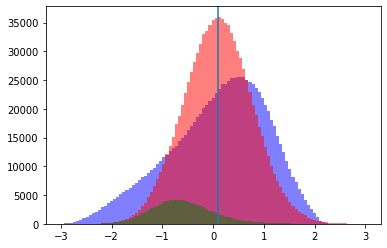

In [77]:
bins = np.linspace(-3,3,100)
bins.shape
column = 7
print(f_rnd.columns[column])
plt.hist(X[bkg_idx,column],bins,alpha=0.5,color='b');
plt.hist(out[:,column],bins,alpha=0.5,color='r');
plt.hist(out2[:,column],bins,alpha=0.5,color='g');
plt.axvline(np.mean(X[bkg_idx,column]))

In [78]:
X[signal_idx].shape

(99829, 12)

In [89]:
loss_bkg = get_loss(X[bkg_idx])
loss_sig = get_loss(X[signal_idx])

(992924, 12)
(99829, 12)


In [90]:
loss_bkg

array([0.3900876 , 0.8378627 , 0.5801927 , ..., 0.4310437 , 0.18108658,
       0.6342451 ], dtype=float32)

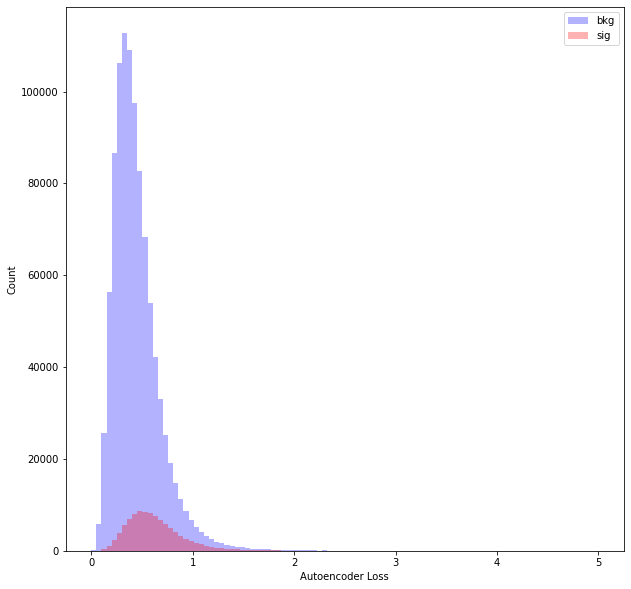

In [91]:
plt.rcParams["figure.figsize"] = (10,10)
bins = np.linspace(0,5,100)
plt.hist(loss_bkg,bins=bins,alpha=0.3,color='b',label='bkg')
plt.hist(loss_sig,bins=bins,weights=np.ones(len(loss_sig))*1,alpha=0.3,color='r',label='sig')
plt.xlabel(r'Autoencoder Loss')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

In [92]:
def get_tpr_fpr(sigloss,bkgloss,aetype='sig'):
    bins = np.linspace(0,50,1001)
    tpr = []
    fpr = []
    for cut in bins:
        if aetype == 'sig':
            tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
            fpr.append(np.where(bkgloss<cut)[0].shape[0]/len(bkgloss))
        if aetype == 'bkg':
            tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
            fpr.append(np.where(bkgloss>cut)[0].shape[0]/len(bkgloss))
    return tpr,fpr        

In [93]:
bkg_tpr5, bkg_fpr5 = get_tpr_fpr(loss_sig,loss_bkg,aetype='bkg')

In [85]:
np.save('NFLOWVAE_PlanarNEW_bkgAE_fpr.npy',bkg_fpr)
np.save('NFLOWVAE_PlanarNEW_bkgAE_tpr.npy',bkg_tpr)

NameError: name 'bkg_fpr' is not defined

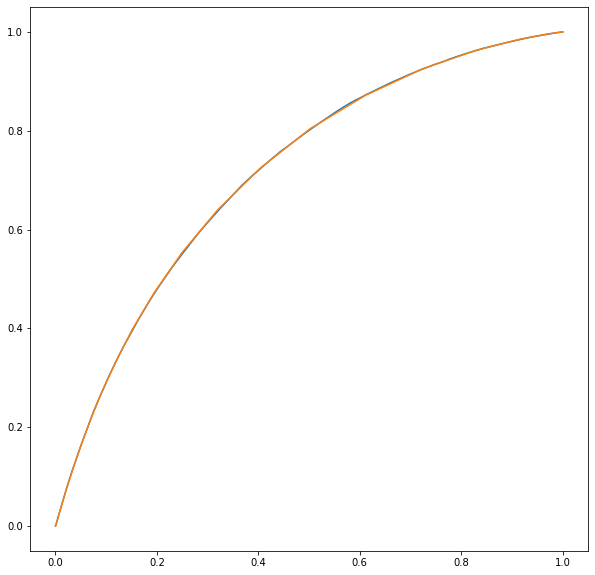

In [94]:
#plt.plot(bkg_fpr,bkg_tpr,label='Bkg NFlowVAE-Planar')
#plt.plot(bkg_fpr2,bkg_tpr2,label='Bkg NFlowVAE-Planar (w/mass)')
#plt.plot(bkg_fpr3,bkg_tpr3,label='Bkg NFlowVAE-Planar (w/mass)')
plt.plot(bkg_fpr4,bkg_tpr4,label='Bkg NFlowVAE-Planar cwola')
plt.plot(bkg_fpr5,bkg_tpr5,label='Bkg NFlowVAE-Planar cwola(mean)')

# Signal Autoencoder

In [4]:
prong_2 = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5")
prong_3 = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_3prong_rnd.h5")

In [5]:
#nprong = 2
nprong = 3

In [6]:
nprong

3

In [7]:
if nprong == 2:
    dt = prong_2.values
    correct = (dt[:,3]>0) &(dt[:,19]>0)
    dt = dt[correct]
    for i in range(13,19):
        dt[:,i] = dt[:,i]/dt[:,3]
    
    for i in range(29,35):
        dt[:,i] = dt[:,i]/(dt[:,19])

    correct = (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
    dt = dt[correct]
    
    
    #Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
    Y = dt[:,[4,5,6,11,12,13,14,15,16,17,18,20,21,22,27,28,29,30,31,32,33,34]] # When no jet 1,2 raw mass included
    #Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
    idx = dt[:,-1]
    bkg_idx = np.where(idx==0)[0]
    signal_idx = np.where((idx==1) & (dt[:,3]>300)) [0]
    #signal_idx = np.where((idx==1)) [0]
    Y = Y[signal_idx]
    
    
if nprong == 3:
    dt = prong_3.values
    correct = (dt[:,3]>20) &(dt[:,19]>20)
    dt = dt[correct]
    for i in range(13,19):
        dt[:,i] = dt[:,i]/dt[:,3]
    
    for i in range(29,35):
        dt[:,i] = dt[:,i]/(dt[:,19])
        
    correct = (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
    dt = dt[correct]        
        
    Y = dt[:,[4,5,6,11,12,13,14,15,16,17,18,20,21,22,27,28,29,30,31,32,33,34]]
    #Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
    idx = dt[:,-1]
    bkg_idx = np.where(idx==0)[0]
    signal_idx = np.where((idx==1) & (dt[:,3]>400))[0]
    Y = Y[signal_idx]
    


In [8]:
Y.shape

(58817, 22)

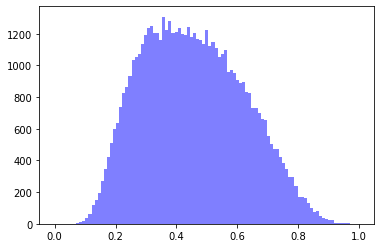

In [9]:
bins = np.linspace(0,1,100)
bins.shape
column = 1
#print(f_rnd.columns[column])
plt.hist(Y[:,column],bins,alpha=0.5,color='b');
#plt.hist(sigout[:,column],bins,alpha=0.5,color='r');
#plt.hist(out2[:,column],bins,alpha=0.5,color='g');
#plt.axvline(np.mean(Y[:,column]))

In [10]:
Y.shape

(58817, 22)

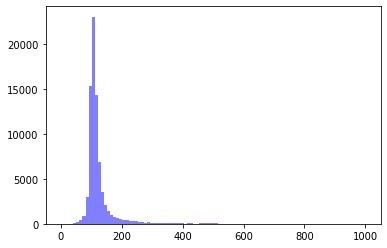

In [11]:
bins = np.linspace(0,1000,100)
bins.shape
column = 0
#print(f_rnd.columns[column])
plt.hist(dt[:,19],bins,alpha=0.5,color='b');
#plt.hist(sigout[:,column],bins,alpha=0.5,color='r');
#plt.hist(out2[:,column],bins,alpha=0.5,color='g');
#plt.axvline(np.mean(Y[:,column]))

In [12]:
sig_mean = []
sig_std = []
for i in range(22):
    mean = np.mean(Y[:,i])
    std = np.std(Y[:,i])
    sig_mean.append(mean)
    sig_std.append(std)
    Y[:,i] = (Y[:,i]-mean)/std

In [13]:
sig_mean

[0.387220838556547,
 0.4550481395999832,
 0.7410030509654335,
 1.2460849327388506,
 323.683220837513,
 0.9721762372503185,
 0.962817098477744,
 0.9785325654730389,
 0.9905189535098495,
 0.9946359132255161,
 0.9149130859612646,
 0.5280381573160862,
 0.654425383481654,
 0.7590377626963312,
 1.5639366470592968,
 179.78230783616982,
 0.8880956437559158,
 0.7102234639174522,
 0.7281219620654653,
 0.8658417851464313,
 0.9054291606677237,
 0.009230746538430614]

In [14]:
sig_std

[0.1297745644783695,
 0.1654354420637481,
 0.11762066755360992,
 0.1868880203297905,
 87.70554645676953,
 0.029742918766739204,
 0.07741156763615237,
 0.07607878292762893,
 0.03963969626411011,
 0.023319004816736356,
 0.22062860793880676,
 0.13613612930963886,
 0.12473186192522633,
 0.10128216462797296,
 0.4520952413970693,
 51.46734609359927,
 0.1509736948976022,
 0.244853004137407,
 0.26993650798423124,
 0.16761592487490215,
 0.13193608703006593,
 0.09364734760555429]

In [15]:
total_sig = torch.tensor(Y)

In [16]:
total_sig.shape

torch.Size([58817, 22])

In [17]:
N_EPOCHS = 30
PRINT_INTERVAL = 2000
NUM_WORKERS = 4
LR = 1e-6

N_FLOWS = 6 
Z_DIM = 8

#N_FLOWS = 3 
#Z_DIM = 6

n_steps = 0

In [18]:
sigmodel = VAE_NF(N_FLOWS, Z_DIM).cuda()

In [19]:
print(sigmodel)

VAE_NF(
  (encoder): Sequential(
    (0): Linear(in_features=22, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=True)
    (2): Linear(in_features=50, out_features=48, bias=True)
    (3): LeakyReLU(negative_slope=True)
    (4): Linear(in_features=48, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=48, bias=True)
    (1): LeakyReLU(negative_slope=True)
    (2): Linear(in_features=48, out_features=50, bias=True)
    (3): LeakyReLU(negative_slope=True)
    (4): Linear(in_features=50, out_features=22, bias=True)
  )
  (flows): NormalizingFlowModel(
    (flows): ModuleList(
      (0): MAF(
        (layers): ModuleList(
          (0): FCNN(
            (network): Sequential(
              (0): Linear(in_features=1, out_features=8, bias=True)
              (1): Tanh()
              (2): Linear(in_features=8, out_features=8, bias=True)
              (3): Tanh()
              (4): Linear(in_features=8, out_features=2, bias=True)

In [20]:
bs = 800
sig_train_iterator = utils.DataLoader(total_sig, batch_size=bs, shuffle=True) 
sig_test_iterator = utils.DataLoader(total_sig, batch_size=bs)

In [21]:
sigoptimizer = optim.Adam(sigmodel.parameters(), lr=1e-4)

In [23]:
beta = 0.1

In [24]:
def sigtrain():
    global n_steps
    train_loss = []
    sigmodel.train()

    for batch_idx, x in enumerate(sig_train_iterator):
        start_time = time.time()
        
        x = x.float().cuda()

        x_tilde, kl_div = sigmodel(x)
        mseloss = nn.MSELoss(size_average=False)
        huberloss = nn.SmoothL1Loss(size_average=False)
        #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
        loss_recons = mseloss(x_tilde,x ) / x.size(0)
        #loss_recons = huberloss(x_tilde,x ) / x.size(0)
        loss = loss_recons + beta* kl_div

        sigoptimizer.zero_grad()
        loss.backward()
        sigoptimizer.step()

        train_loss.append([loss_recons.item(), kl_div.item()])

        if (batch_idx + 1) % PRINT_INTERVAL == 0:
            print('\tIter [{}/{} ({:.0f}%)]\tLoss: {} Time: {:5.3f} ms/batch'.format(
                batch_idx * len(x), 50000,
                PRINT_INTERVAL * batch_idx / 50000,
                np.asarray(train_loss)[-PRINT_INTERVAL:].mean(0),
                1000 * (time.time() - start_time)
            ))

        n_steps += 1

In [25]:
def sigevaluate(split='valid'):
    global n_steps
    start_time = time.time()
    val_loss = []
    sigmodel.eval()

    with torch.no_grad():
        for batch_idx, x in enumerate(sig_test_iterator):
            
            x = x.float().cuda()

            x_tilde, kl_div = sigmodel(x)
            mseloss = nn.MSELoss(size_average=False)
            huberloss = nn.SmoothL1Loss(size_average=False)
            #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
            loss_recons = mseloss(x_tilde,x ) / x.size(0)
            #loss_recons = huberloss(x_tilde,x ) / x.size(0)
            loss = loss_recons + beta * kl_div

            val_loss.append(loss.item())
            #writer.add_scalar('loss/{}/ELBO'.format(split), loss.item(), n_steps)
            #writer.add_scalar('loss/{}/reconstruction'.format(split), loss_recons.item(), n_steps)
            #writer.add_scalar('loss/{}/KL'.format(split), kl_div.item(), n_steps)

    print('\nEvaluation Completed ({})!\tLoss: {:5.4f} Time: {:5.3f} s'.format(
        split,
        np.asarray(val_loss).mean(0),
        time.time() - start_time
    ))
    return np.asarray(val_loss).mean(0)

In [26]:
ae_def = {
    "type":"sig",
    "trainon":"3prong",
    "features":"CwolaMassRatioNoRawMass",
    "architecture":"MAF",
    "selection":"withturnoncuts",
    "trainloss":"MSELoss",
    "beta":"beta0p1",
}

In [27]:
ae_def

{'type': 'sig',
 'trainon': '3prong',
 'features': 'CwolaMassRatioNoRawMass',
 'architecture': 'MAF',
 'selection': 'withturnoncuts',
 'trainloss': 'MSELoss',
 'beta': 'beta0p1'}

In [28]:
N_EPOCHS = 10
BEST_LOSS = 999
LAST_SAVED = -1
PATIENCE_COUNT = 0
PATIENCE_LIMIT = 5
for epoch in range(1, 1000):
    print("Epoch {}:".format(epoch))
    sigtrain()
    cur_loss = sigevaluate()

    if cur_loss <= BEST_LOSS:
        PATIENCE_COUNT = 0
        BEST_LOSS = cur_loss
        LAST_SAVED = epoch
        print("Saving model!")
        torch.save(sigmodel.state_dict(),f"/data/t3home000/spark/QUASAR/weights/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}.h5")
        
    else:
        PATIENCE_COUNT += 1
        print("Not saving model! Last saved: {}".format(LAST_SAVED))
        if PATIENCE_COUNT > 10:
            print("Patience Limit Reached")
            break 

Epoch 1:


/home/spark/miniconda3/envs/myenv/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Evaluation Completed (valid)!	Loss: 22.5944 Time: 0.744 s
Saving model!
Epoch 2:

Evaluation Completed (valid)!	Loss: 18.8046 Time: 0.743 s
Saving model!
Epoch 3:

Evaluation Completed (valid)!	Loss: 16.5812 Time: 0.780 s
Saving model!
Epoch 4:

Evaluation Completed (valid)!	Loss: 15.6863 Time: 0.747 s
Saving model!
Epoch 5:

Evaluation Completed (valid)!	Loss: 14.8993 Time: 0.748 s
Saving model!
Epoch 6:

Evaluation Completed (valid)!	Loss: 14.1331 Time: 0.748 s
Saving model!
Epoch 7:

Evaluation Completed (valid)!	Loss: 13.4494 Time: 0.748 s
Saving model!
Epoch 8:

Evaluation Completed (valid)!	Loss: 12.7568 Time: 0.747 s
Saving model!
Epoch 9:

Evaluation Completed (valid)!	Loss: 12.0180 Time: 0.745 s
Saving model!
Epoch 10:

Evaluation Completed (valid)!	Loss: 11.1869 Time: 0.751 s
Saving model!
Epoch 11:

Evaluation Completed (valid)!	Loss: 10.4634 Time: 0.748 s
Saving model!
Epoch 12:

Evaluation Completed (valid)!	Loss: 9.8114 Time: 0.779 s
Saving model!
Epoch 13:

Evaluation C


Evaluation Completed (valid)!	Loss: 3.6009 Time: 0.739 s
Not saving model! Last saved: 93
Epoch 96:

Evaluation Completed (valid)!	Loss: 3.5834 Time: 0.740 s
Not saving model! Last saved: 93
Epoch 97:

Evaluation Completed (valid)!	Loss: 3.5816 Time: 0.740 s
Not saving model! Last saved: 93
Epoch 98:

Evaluation Completed (valid)!	Loss: 3.4430 Time: 0.741 s
Saving model!
Epoch 99:

Evaluation Completed (valid)!	Loss: 3.3980 Time: 0.739 s
Saving model!
Epoch 100:

Evaluation Completed (valid)!	Loss: 3.5859 Time: 0.738 s
Not saving model! Last saved: 99
Epoch 101:

Evaluation Completed (valid)!	Loss: 3.5356 Time: 0.739 s
Not saving model! Last saved: 99
Epoch 102:

Evaluation Completed (valid)!	Loss: 3.4384 Time: 0.739 s
Not saving model! Last saved: 99
Epoch 103:

Evaluation Completed (valid)!	Loss: 3.6288 Time: 0.741 s
Not saving model! Last saved: 99
Epoch 104:

Evaluation Completed (valid)!	Loss: 3.3972 Time: 0.749 s
Saving model!
Epoch 105:

Evaluation Completed (valid)!	Loss: 3.47

In [43]:
sigmodel.load_state_dict(torch.load(f"/data/t3home000/spark/QUASAR/weights/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}.h5"))

<All keys matched successfully>

In [44]:
sigout = sigmodel(torch.tensor(Y).float().cuda())[0]
sigout = sigout.data.cpu().numpy()

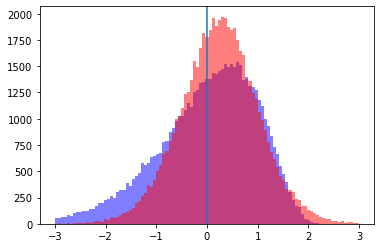

In [61]:
bins = np.linspace(-3,3,100)
bins.shape
column = 13
#print(f_rnd.columns[column]
plt.hist(Y[:,column],bins,alpha=0.5,color='b');
plt.hist(sigout[:,column],bins,alpha=0.5,color='r');
#plt.hist(out2[:,column],bins,alpha=0.5,color='g');
plt.axvline(np.mean(Y[:,column]))

In [62]:
inputlist = [
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB1_rnd.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB2.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB3.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_background.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5', 
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_3prong_rnd.h5' 
]

In [63]:
outputlist = [
    '../data_strings/sigae_3prong_withmassNORAWJETMASS_turnonselection_Huberloss_beta1_WAICloss_bb1.npy',
    '../data_strings/sigae_3prong_withmassNORAWJETMASS_turnonselection_Huberloss_beta1_WAICloss_bb2.npy',
    '../data_strings/sigae_3prong_withmassNORAWJETMASS_turnonselection_Huberloss_beta1_WAICloss_bb3.npy',
    '../data_strings/sigae_3prong_withmassNORAWJETMASS_turnonselection_Huberloss_beta1_WAICloss_purebkg.npy',
    '../data_strings/sigae_3prong_withmassNORAWJETMASS_turnonselection_Huberloss_beta1_WAICloss_rndbkg.npy',
    '../data_strings/sigae_3prong_withmassNORAWJETMASS_turnonselection_Huberloss_beta1_WAICloss_2prong.npy',
    '../data_strings/sigae_3prong_withmassNORAWJETMASS_turnonselection_Huberloss_beta1_WAICloss_3prong.npy',
]

In [64]:
exist_signalflag = [
    False,
    False,
    False,
    False,
    True,
    True,
    True,
]
is_signal = [
    False,
    False,
    False,
    False,
    False,
    True,
    True
]

nprong = [
    None,
    None,
    None,
    None,
    None,
    '2prong',
    '3prong'
]

(914617, 22)
[ 0.8393213  1.8810232  2.356104   0.8825512  1.7487564 17.712952
 27.551426  40.08393    3.3866887  8.730786 ]
(902602, 22)
[ 6.8991404  5.7540126 14.433657   2.0291429 65.7177     8.218711
 61.73116   54.045055  81.01951    6.0470285]
(938250, 22)
[16.658262  64.237976   5.7001877  1.2812992  1.5830371  2.6877186
  8.365374   7.9900765  5.258966   2.9627826]
(930647, 22)
[ 1.7457403 22.05825    9.129873  14.333065  37.89096   16.518042
 36.73714    3.9526708  1.3841065 27.603506 ]
(938331, 22)
[75.53003    2.4559917  2.3027852  4.2289796  2.689762   3.648775
 13.365385  71.755165   1.4970752 52.240833 ]
(0, 22)
[]
(0, 22)
[]


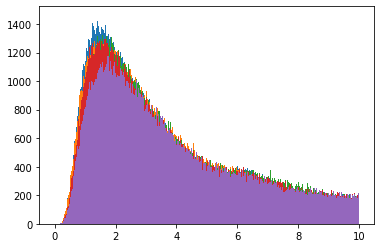

In [65]:
for in_file, out_file, sigbit_flag, is_sig, n_prong in zip(inputlist,outputlist,exist_signalflag,is_signal, nprong):
    f_bb = pd.read_hdf(in_file)
    dt = f_bb.values

    correct = (dt[:,3]>0) &(dt[:,19]>0)
    dt = dt[correct]
    for i in range(13,19):
        dt[:,i] = dt[:,i]/dt[:,3]
    
    for i in range(29,35):
        dt[:,i] = dt[:,i]/(dt[:,19])
        
        
    correct = (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
    dt = dt[correct]
    Y = dt[:,[4,5,6,11,12,13,14,15,16,17,18,20,21,22,27,28,29,30,31,32,33,34]]
    #Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
    #Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
    if sigbit_flag:
        idx = dt[:,-1]
        sigidx = (idx == 1)
        bkgidx = (idx == 0)
        if is_sig:
            Y = Y[sigidx]
        else:
            Y = Y[bkgidx]
            
    if n_prong == '2prong':
        correct = Y[:,0] > 300
        Y = Y[correct]
    
    if n_prong == '3prong':
        correct = Y[:,0] > 400
        Y = Y[correct]
        
    
            
    print(Y.shape)
    for i in range(22):
        Y[:,i] = (Y[:,i]-sig_mean[i])/sig_std[i]
    
    total_bb_test = torch.tensor(Y)
    sigae_bbloss = torch.mean((sigmodel(total_bb_test.float().cuda())[0]- total_bb_test.float().cuda())**2,dim=1).data.cpu().numpy()
    bbvar = torch.var((sigmodel(total_bb_test.float().cuda())[0]- total_bb_test.float().cuda())**2,dim=1).data.cpu().numpy()
    waic = sigae_bbloss + bbvar
    print(sigae_bbloss[0:10])
    plt.hist(sigae_bbloss,bins=np.linspace(0,10,1001));
    np.save(out_file,sigae_bbloss)

In [53]:
loss_prong3 = np.load('../data_strings/sigae_2prong_withmassNORAWJETMASS_turnonselection_MSEloss_beta1_WAICloss_3prong.npy')
loss_prong2 = np.load('../data_strings/sigae_2prong_withmassNORAWJETMASS_turnonselection_MSEloss_beta1_WAICloss_2prong.npy')
loss_purebkg = np.load('../data_strings/sigae_2prong_withmassNORAWJETMASS_turnonselection_MSEloss_beta1_WAICloss_purebkg.npy')
loss_rndbkg = np.load('../data_strings/sigae_2prong_withmassNORAWJETMASS_turnonselection_MSEloss_beta1_WAICloss_rndbkg.npy')

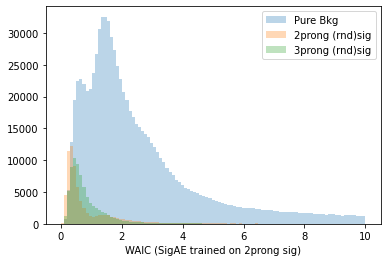

In [56]:
plt.hist(loss_purebkg,bins=np.linspace(0,10,100),density=False,alpha=0.3,label='Pure Bkg');
#plt.hist(loss_rndbkg,bins=np.linspace(0,30,100),density=True,alpha=0.3,label='(rnd) bkg');

plt.hist(loss_prong2,bins=np.linspace(0,10,100),density=False,alpha=0.3,label='2prong (rnd)sig');
plt.hist(loss_prong3,bins=np.linspace(0,10,100),density=False,alpha=0.3,label='3prong (rnd)sig');
#plt.yscale('log')
plt.xlabel('WAIC (SigAE trained on 2prong sig)')
plt.legend(loc='upper right')
plt.savefig('sigae_trained_on_2prongsig_onlybkg.png')

In [34]:
sigae_bbloss

array([ 2832.3672,  8125.47  , 29922.496 , ...,  2359.0386,  2635.9333,
         640.2169], dtype=float32)

In [27]:
sigae_bbloss

array([  13148.348 , 1877521.2   ,   10748.764 , ...,    9332.388 ,
          3072.496 ,    3093.0527], dtype=float32)

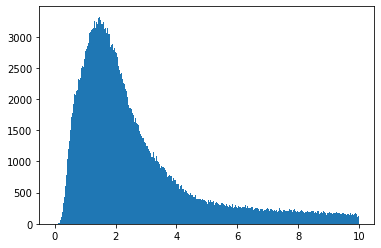

In [59]:
plt.hist(sigae_bbloss,bins=np.linspace(0,10,1001));

In [60]:
np.save('../data_strings/sigae_2prong_loss_bb3.npy',sigae_bbloss)

In [211]:
X_bkg = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
X_bkg = X_bkg[bkg_idx]

In [212]:
for i in range(12):
    X_bkg[:,i] = (X_bkg[:,i]-sig_mean[i])/sig_std[i]

In [161]:
total_bkg_test = torch.tensor(X_bkg)

In [162]:
sigae_bkgloss = torch.mean((sigmodel(total_bkg_test.float().cuda())[0]- total_bkg_test.float().cuda())**2,dim=1).data.cpu().numpy()

In [163]:
sigae_sigloss = torch.mean((sigmodel(total_sig.float().cuda())[0]- total_sig.float().cuda())**2,dim=1).data.cpu().numpy()

In [176]:
f_3prong = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_3prong_rnd.h5")

In [309]:
f_bb1 = pd.read_hdf('/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB1_rnd.h5')

In [310]:
dt_bb1 = f_bb1.values

In [311]:
X_bb1 = dt_bb1[:,[3,4,5,6,11,12,19,20,21,22,27,28]]

In [312]:
X_bb1.shape

(1000000, 12)

In [313]:
sig_mean

[416.4436327724198,
 0.259460143970101,
 0.6475599434564594,
 0.7747571031756559,
 1.4414801240204307,
 232.28881387172063,
 115.19219609387073,
 0.4000458937255977,
 0.6497184345343743,
 0.7592483240780288,
 1.5724873295094448,
 139.77741938715204]

In [314]:
sig_std

[154.19379540115423,
 0.17056704944179107,
 0.14978212617036485,
 0.09894407762923978,
 0.4886539241053714,
 87.70941099970253,
 49.68849330603538,
 0.1622952691607605,
 0.14863130231138283,
 0.10503384225762816,
 0.6713928483438475,
 48.672440905600446]

In [315]:
for i in range(12):
    X_bb1[:,i] = (X_bb1[:,i]-sig_mean[i])/sig_std[i]

(array([246458., 189649., 134796.,  95188.,  64278.,  40409.,  20912.,
          9337.,   4219.]),
 array([-2.        , -1.55555556, -1.11111111, -0.66666667, -0.22222222,
         0.22222222,  0.66666667,  1.11111111,  1.55555556,  2.        ]),
 <a list of 9 Patch objects>)

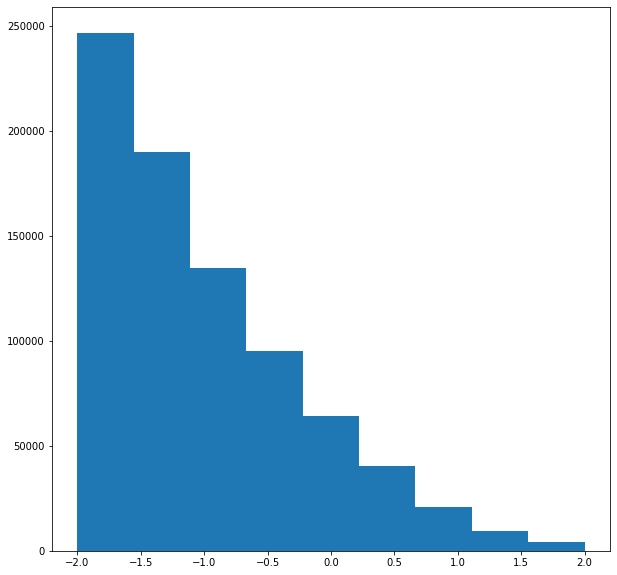

In [317]:
plt.hist(X_bb1[:,0],bins = np.linspace(-2,2,10))

In [318]:
(torch.tensor(dt[i * chunk_size:(i + 1) * chunk_size]) for i in range ) 

TypeError: 'type' object is not iterable

In [319]:
def get_loss(dt):
    
    chunk_size=5000 
    total_size=1000000
    i = 0
    i_max = total_size // chunk_size

    print(i_max)
    
    
    
    gen = (torch.tensor(dt[i*chunk_size: (i + 1) * chunk_size]) for i in range(i_max)) 

        
    with torch.no_grad():
        
        loss = [
            n
            for total_in_selection in gen
            for n in torch.mean((sigmodel(total_in_selection.float().cuda())[0]- total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy()
        ]
        
    return loss

In [287]:
def get_loss(dt):
    
    def generator(dt, chunk_size=5000, total_size=1000000):

        i = 0
        i_max = total_size // chunk_size
        print(i_max)
    
        for i in range(i_max):
            start=i * chunk_size
            stop=(i + 1) * chunk_size
            yield torch.tensor(dt[start:stop])
        
    loss = []

    
    with torch.no_grad():
        
        for total_in_selection in generator(dt,chunk_size=5000, total_size=1000000):
            loss.extend(torch.mean((sigmodel(total_in_selection.float().cuda())[0]- total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy())
    
    return loss

In [320]:
bb1_loss_sig = get_loss(X_bb1)

200


In [321]:
bb1_loss_sig = np.array(bb1_loss_sig,dtype=np.float)

In [322]:
print(bb1_loss_sig)

[1.90564466 0.96934295 1.35960376 ... 0.59359992 2.21692467 2.44283652]


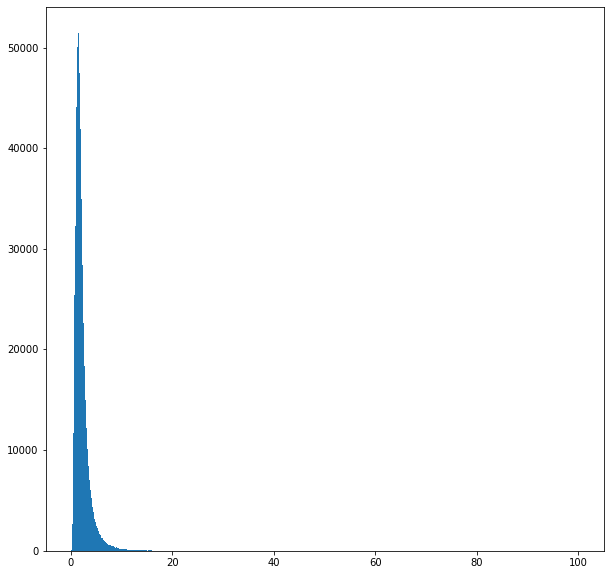

In [323]:
plt.hist(bb1_loss_sig,bins=np.linspace(0,100,1001));

In [324]:
np.save('../data_strings/sigaeloss_bb1.npy',bb1_loss_sig)

In [177]:
dt_3prong = f_3prong.values

In [178]:
Z = dt_3prong[:,[3,4,5,6,11,12,19,20,21,22,27,28]]

In [179]:
Z.shape

(100000, 12)

In [180]:
for i in range(12):
    Z[:,i] = (Z[:,i]-sig_mean[i])/sig_std[i]

In [181]:
total_3prong = torch.tensor(Z)

In [199]:
bkgae_bkgloss = torch.mean((model(total_bkg_test.float().cuda())[0]- total_bkg_test.float().cuda())**2,dim=1).data.cpu().numpy()

In [ ]:
bkgae_3prongloss = torch.mean((model(total_3prong.float().cuda())[0]- total_3prong.float().cuda())**2,dim=1).data.cpu().numpy()

In [182]:
sigae_3prongloss = torch.mean((sigmodel(total_3prong.float().cuda())[0]- total_3prong.float().cuda())**2,dim=1).data.cpu().numpy()

In [183]:
sigae_3prongloss.shape

(100000,)

Text(0.5, 0, 'Signal AE Loss')

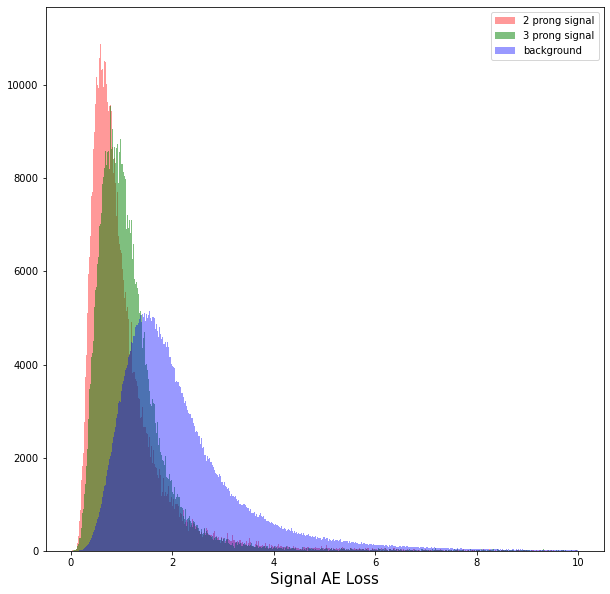

In [216]:
bins = np.linspace(0,10,1001)
plt.hist(sigae_sigloss,bins,weights = np.ones(len(signal_idx))*10,alpha=0.4,color='r',label='2 prong signal');
plt.hist(sigae_3prongloss,bins,weights = np.ones(100000)*10,alpha=0.5,color='g',label='3 prong signal');
plt.hist(sigae_bkgloss,bins,alpha=0.4,color='b',label='background');
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend(loc='upper right')
plt.xlabel('Signal AE Loss',fontsize=15)



In [193]:
def get_tpr_fpr(sigloss,bkgloss,aetype='sig'):
    bins = np.linspace(0,50,1001)
    tpr = []
    fpr = []
    for cut in bins:
        if aetype == 'sig':
            tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
            fpr.append(np.where(bkgloss<cut)[0].shape[0]/len(bkgloss))
        if aetype == 'bkg':
            tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
            fpr.append(np.where(bkgloss>cut)[0].shape[0]/len(bkgloss))
    return tpr,fpr      

In [194]:
def get_precision_recall(sigloss,bkgloss,aetype='bkg'):
    bins = np.linspace(0,100,1001)
    tpr = []
    fpr = []
    precision = []
    for cut in bins:
        if aetype == 'sig':
            tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
            precision.append((np.where(sigloss<cut)[0].shape[0])/(np.where(bkgloss<cut)[0].shape[0]+np.where(sigloss<cut)[0].shape[0]))
            
        if aetype == 'bkg':
            tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
            precision.append((np.where(sigloss>cut)[0].shape[0])/(np.where(bkgloss>cut)[0].shape[0]+np.where(sigloss>cut)[0].shape[0]))
    return precision,tpr      

In [196]:
tpr_2prong, fpr_2prong = get_tpr_fpr(sigae_sigloss,sigae_bkgloss,'sig')
tpr_3prong, fpr_3prong = get_tpr_fpr(sigae_3prongloss,sigae_bkgloss,'sig')

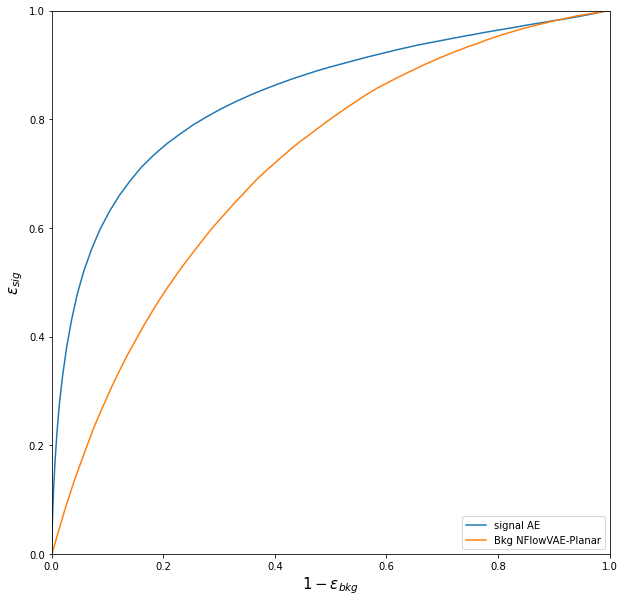

In [217]:
plt.plot(fpr_2prong,tpr_2prong,label='signal AE')
#plt.plot(VAE_bkg_fpr,VAE_bkg_tpr,label='Bkg VAE-Vanilla')
plt.plot(bkg_fpr4,bkg_tpr4,label='Bkg NFlowVAE-Planar')

plt.xlabel(r'$1-\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend(loc='lower right')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.savefig('ROC_Curve_sigae.png')

In [ ]:
precision,recall = get_precision_recall(loss_sig,loss_bkg,aetype='bkg')

In [ ]:
np.save('NFLOWVAE_PlanarNEW_22var_sigloss.npy',loss_sig)
np.save('NFLOWVAE_PlanarNEW_22var_bkgloss.npy',loss_bkg)

In [ ]:
np.save('NFLOWVAE_PlanarNEW_precision.npy',precision)
np.save('NFLOWVAE_PlanarNEW_recall.npy',recall)
np.save('NFLOWVAE_PlanarNEW_bkgAE_fpr.npy',bkg_fpr)
np.save('NFLOWVAE_PlanarNEW_bkgAE_tpr.npy',bkg_tpr)
np.save('NFLOWVAE_PlanarNEW_sigloss.npy',loss_sig)
np.save('NFLOWVAE_PlanarNEW_bkgloss.npy',loss_bkg)

In [ ]:
plt.plot(recall,precision)

In [ ]:
flows = [1,2,3,4,5,6]
zdim = [1,2,3,4,5]

for N_flows in flows:
    for Z_DIM in zdim:
        model = VAE_NF(N_FLOWS, Z_DIM).cuda()
        optimizer = optim.Adam(model.parameters(), lr=LR)
        BEST_LOSS = 99999
        LAST_SAVED = -1
        PATIENCE_COUNT = 0
        PATIENCE_LIMIT = 5
        for epoch in range(1, N_EPOCHS):
            print("Epoch {}:".format(epoch))
            train()
            cur_loss = evaluate()

            if cur_loss <= BEST_LOSS:
                PATIENCE_COUNT = 0
                BEST_LOSS = cur_loss
                LAST_SAVED = epoch
                print("Saving model!")
                if mode == 'ROC':
                    torch.save(model.state_dict(),f"/data/t3home000/spark/QUASAR/weights/bkg_vae_NF_planar_RND_22var_z{Z_DIM}_f{N_FLOWS}.h5")
                else:
                    torch.save(model.state_dict(), f"/data/t3home000/spark/QUASAR/weights/bkg_vae_NF_planar_PureBkg_22var_z{Z_DIM}_f{N_FLOWS}.h5")
            else:
                PATIENCE_COUNT += 1
                print("Not saving model! Last saved: {}".format(LAST_SAVED))
                if PATIENCE_COUNT > 3:
                    print("Patience Limit Reached")
                    break 
                    
        loss_bkg = get_loss(dt_PureBkg[bkg_idx])
        loss_sig = get_loss(dt_PureBkg[signal_idx])
        np.save(f'NFLOWVAE_PlanarNEW_22var_z{Z_DIM}_f{N_flows}_sigloss.npy',loss_sig)
        np.save(f'NFLOWVAE_PlanarNEW_22var_z{Z_DIM}_f{N_flows}_bkgloss.npy',loss_bkg)